In [1]:
import zipfile, itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import contractions

from IPython.display import display
from tqdm.notebook import tqdm
from unicodedata import normalize as unicode_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/omar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/omar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/omar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/omar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Description

"The ISOT Fake News dataset is a compilation of several thousands fake news and truthful articles, obtained from different legitimate news sites and sites flagged as unreliable by Politifact.com" From [Information security and object technology (ISOT) research lab](https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php)

The news articles in this data set was collected from real-world sources. All news articles from the [Reuters](https://www.reuters.com/) were labelled as truthful. The rest of the articles were labelled false since they were flagged by the US fact-checking organization Politifact and Wikipedia. The articles discuss different topics but the majority focus on political and news events in the world. Each article contains the following information: article title, text, type and the publication date. The collection period was 2016 to 2017. The text was somewhat cleaned. The punctuations and mistakes that existed in the fake news were kept in the text. For more details read the paper [*Detecting opinion spams and fake news using text classification*](https://www.researchgate.net/profile/Sherif-Saad-4/publication/322128415_Detecting_opinion_spams_and_fake_news_using_text_classification/links/5de06c1fa6fdcc2837f3d911/Detecting-opinion-spams-and-fake-news-using-text-classification.pdf).

Making the non-fake class consist entirely of Reuters articles is probably not a good idea. Articles from Reuters are clearly **_not_** representative of the real-world distribution of truthful news articles. So we should be aware of the sampling bias inherent in the data collection procedure. Another issue with this data set is that the data was collected 5 years ago. We cannot expect the out-of-sample performance on a model trained on this data set to good.

## Load data

In [3]:
with zipfile.ZipFile("../data/isot/News_dataset.zip") as zf:
    dataframes = {f: pd.read_csv(zf.open(f)) for f in zf.namelist()}

In [4]:
list(dataframes.keys())

['Fake.csv', 'True.csv']

In [5]:
df_news_fake = dataframes["Fake.csv"]
df_news_true = dataframes["True.csv"]
df_news_fake["is_fake"] = True
df_news_true["is_fake"] = False
df_news_true["is_true"] = True
df_news_fake["is_true"] = False


df_news = pd.concat([df_news_fake, df_news_true], ignore_index=True)

## Exploratory Data Analysis & Cleaning

### Overall data balance

In [6]:
df_news[["is_fake"]].value_counts()

is_fake
True       23481
False      21417
dtype: int64

Data is balanced.

### Publication period

In [7]:
df_news["published_at"] = pd.to_datetime(df_news.date, errors="coerce")

In [8]:
n_failed_rows = df_news["published_at"].isnull().sum()
print(f"Number of articles with bad publication dates: {n_failed_rows}")

Number of articles with bad publication dates: 10


The publication date of some of the news articles seem wrong. Let us look at those.

In [9]:
df_news[df_news["published_at"].isnull()]

,title,text,subject,date,is_fake,is_true,published_at
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,True,False,NaT
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,True,False,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,True,False,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,True,False,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,True,False,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,True,False,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,True,False,NaT
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,True,False,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,True,False,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,True,False,NaT


Remove those articles.

In [10]:
df_news = df_news[~df_news["published_at"].isnull()].copy()

Check the publication timeline for the two categories

In [11]:
df_news.groupby("is_fake").agg(
    min_publication_date=("published_at", "min"),
    max_publication_date=("published_at", "max")
)

,min_publication_date,max_publication_date
is_fake,,
False,2016-01-13,2017-12-31
True,2015-03-31,2018-02-19


The timeframe for collecting the fake articles seem to be longer than those of the truthful news articles from Reuters. This is not necessarily a problem but we may need to consider it later.

### Article titles

Before we move on, let us remove duplicates based on the title.

In [12]:
df_news[["title"]].duplicated().sum()

6165

In [13]:
df_news = df_news[~df_news[["title"]].duplicated()].copy()

In [14]:
df_news[["title"]].duplicated().sum()

0

Let us inspect some of titles

In [15]:
with pd.option_context("max_colwidth", None):
    display(df_news[df_news.is_fake][["title", "is_fake"]].sample(5))

,title,is_fake
14077,TRUMP WINS NEW YORK IN A LANDSLIDE: Will Third Place For Cruz Be A Game Changer?,True
12710,BREAKING: UNDERCOVER VIDEO Exposes Hillary’s Dirty Operatives Inciting Violence At Trump Rallies: “We need to win this motherf*cker” [Video],True
8783,Christian Extremists In Oregon Launch Campaign Of Terror Against Family For ‘Race-Mixing’ (VIDEO),True
8022,Baby Dolphin Dies After Tourists Pass It Around For Photos (VIDEO/IMAGES),True
6662,Barbara Boxer DESTROYS Carly Fiorina After She’s Announced As Ted Cruz’s V.P. (Tweets),True


In [16]:
with pd.option_context("max_colwidth", None):
    display(df_news[df_news.is_true][["title", "is_fake"]].sample(5))

,title,is_fake
29292,Acting SEC chair seeks to scale back 'conflict minerals' rule,False
36684,Russian prosecutors seek 10 years in jail for ex-economy minister: agencies,False
30891,"White House says committed to implementing Iran deal, climate change agreement",False
39193,China extends national anthem 'disrespect' law to Hong Kong,False
35702,Beijing evictions leave migrant workers in limbo as winter deepens,False


Observations about fake titles:
- Clickbaity
- Include certain terms such as `VIDEO`, `WATCH`, `PHOTOS`
- Lengths seem to be much longer than non-fakes

Next, we consider whether the length of the title contains signal.

In [17]:
df_news["title_len"] = df_news["title"].str.strip().str.len()

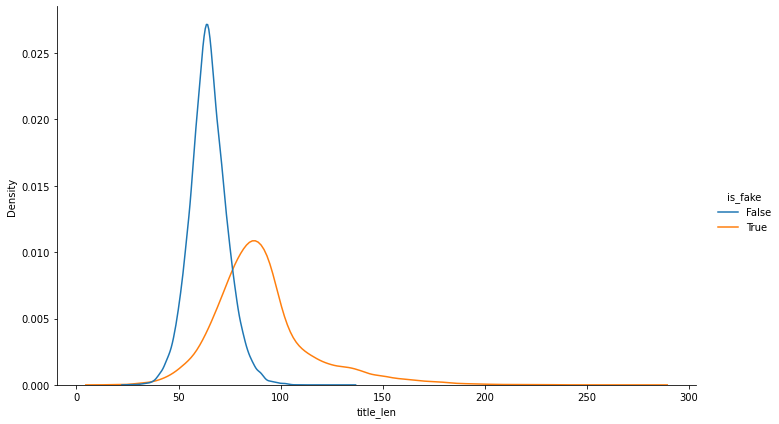

In [18]:
sns.displot(data=df_news, x="title_len", hue="is_fake", kind="kde", height=6, aspect=10/6);

In [19]:
df_news.groupby("is_fake")[["title_len"]].describe()

title_len                                                     
            count       mean        std   min   25%   50%   75%    max
is_fake                                                               
False     20826.0  64.667963   9.150483  26.0  59.0  64.0  70.0  133.0
True      17897.0  90.743812  24.672543  15.0  76.0  87.0  99.0  279.0

- Distribution of the title lenths from Reuters seem to follow a nice Gaussian
- "Fake" titles seem longer, median is 87 characters compared Reuters' 64

In [20]:
with pd.option_context("max_colwidth", None):
    display(df_news[df_news["title_len"] > 133][["title", "is_fake"]].head(5))

,title,is_fake
9053,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chinese Security Official’s Hand Off US Military Aide Carrying Nuclear Football During Trump Meeting In Beijing,True
9062,FACEBOOK’S VP Of Ads BLASTS MEDIA: Majority Of Russian Ad Spend Happened AFTER Election…Media Knows Truth But Won’t Report It “Because It Doesn’t Align With Narrative of Trump And The Election”,True
9065,"“THE TRUMP CURSE IS REAL”…Social Media Responds To Lindsey Vonn’s Olympic Loss, After Saying She’d Boycott White House If She Won Medal",True
9066,"How The Left, The Anti Defamation League and Media Used Fake Information To Publish HUGE LIE About High School Killer’s Ties To “White Nationalist”",True
9076,TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE Story Of How They Led Students Into Classroom…Used Tevlar Mats To Block Bullets From Florida Shooter [VIDEO],True


One interesting observation here is the use of uppercase letters in the title. This could be another telltale sign that a title may be fake.

In [21]:
df_news["title_n_upcase_chars"] = df_news["title"].str.findall(r'[A-Z]').str.len()
df_news["title_uppercase_ratio"] = df_news["title_n_upcase_chars"] / df_news["title_len"]

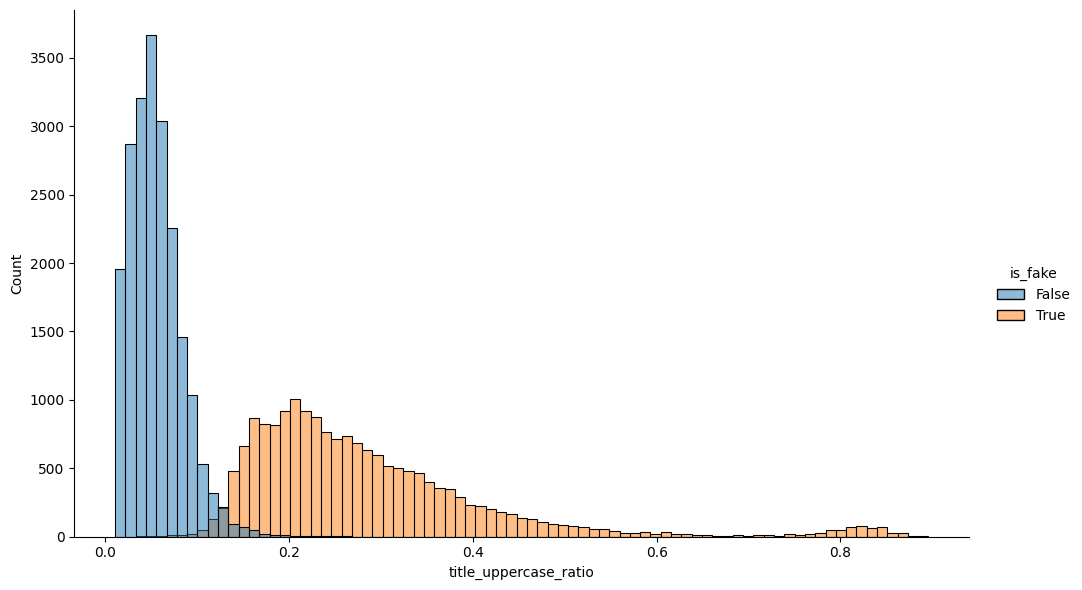

In [22]:
sns.displot(data=df_news, x="title_uppercase_ratio", hue="is_fake", kind="hist", height=6, aspect=10/6);

A typical pre-processing step for text data is to lower-case the input, so the observed pattern above would dissappear. Purely based on the two observations, we can probably deploy a dummy classifier that only considers the length of the title and the usage of uppercase in the title. However, this would not make a good classifier. Excessive use of upercase letters in the title does not necessarily mean that a news article is fake. The observation should be evaluated on a out-of-sample data set.

In [23]:
df_news["title_n_tokens"] = df_news["title"].str.split().map(lambda x: len(x))

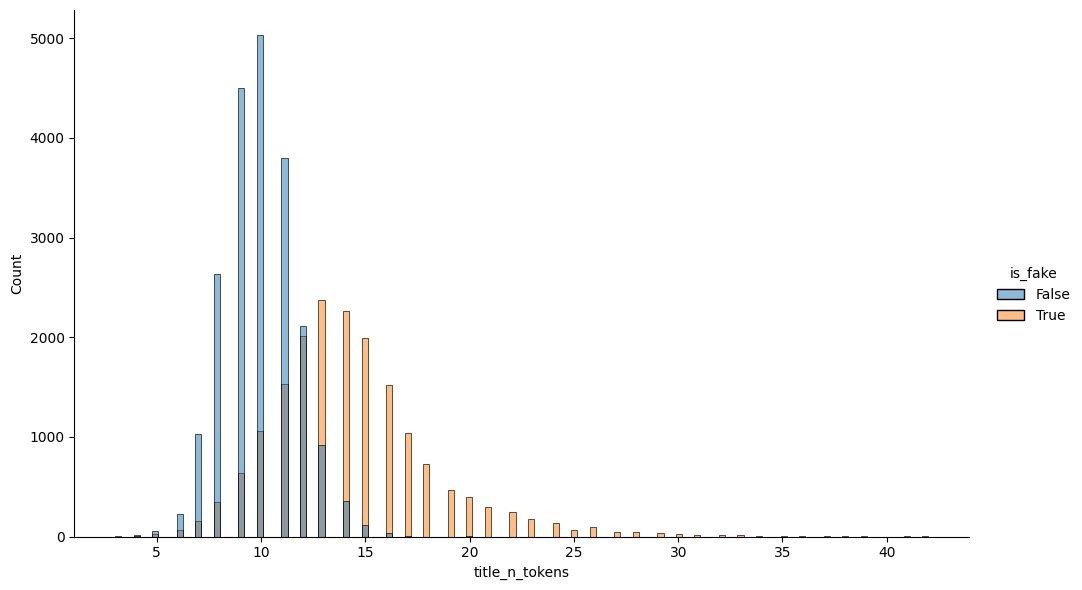

In [24]:
sns.displot(data=df_news, x="title_n_tokens", hue="is_fake", kind="hist", height=6, aspect=10/6);

In [25]:
df_news.groupby("is_fake")[["title_n_tokens"]].describe()

title_n_tokens                                                  
                 count       mean       std  min   25%   50%   75%   max
is_fake                                                                 
False          20826.0   9.950975  1.697126  4.0   9.0  10.0  11.0  20.0
True           17897.0  14.329105  3.959179  3.0  12.0  14.0  16.0  42.0

The average word lengths in the fake titles is on average longer than truthful titles.

Next, we perform n-gram analysis

In [26]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.WordPunctTokenizer()

def tokenize(title):
    fixed_title = unicode_normalize("NFKD", title)
    fixed_title = contractions.fix(fixed_title)
    tokens = tokenizer.tokenize(fixed_title)
    return [
        lemmatizer.lemmatize(token.lower())
        for token in tokens if token.lower() not in stopwords
    ]

In [27]:
df_news["title_tokens"] = df_news["title"].progress_apply(tokenize)

  0%|          | 0/38723 [00:00<?, ?it/s]

In [28]:
all_tokens_fake = pd.Series(itertools.chain(*df_news[df_news.is_fake]["title_tokens"].to_list()))
all_tokens_truth = pd.Series(itertools.chain(*df_news[~df_news.is_fake]["title_tokens"].to_list()))

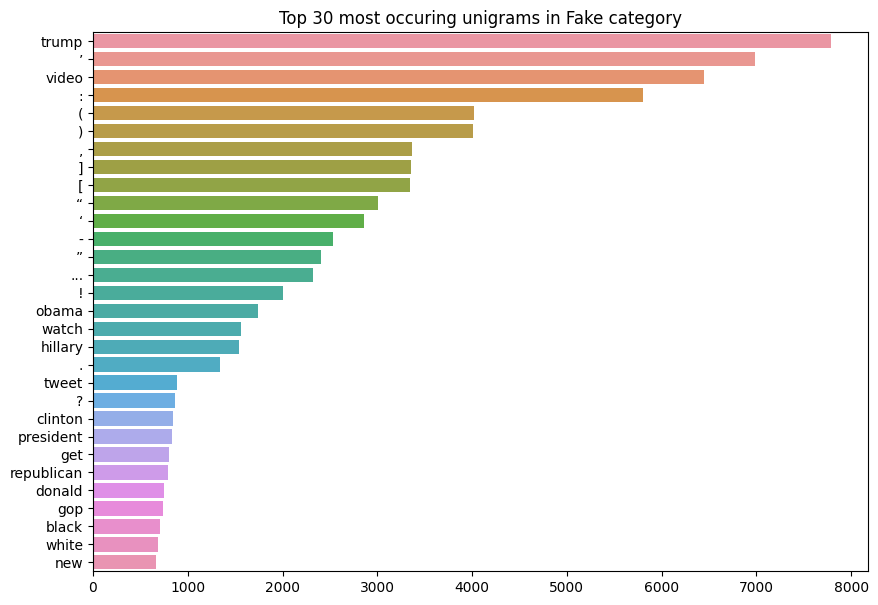

In [29]:
top_k = 30
fig, ax = plt.subplots(figsize=(10, 7))
val_counts = all_tokens_fake.value_counts()[:top_k]
sns.barplot(y=val_counts.index, x=val_counts, ax=ax)
ax.set_title(f"Top {top_k} most occuring unigrams in Fake category");

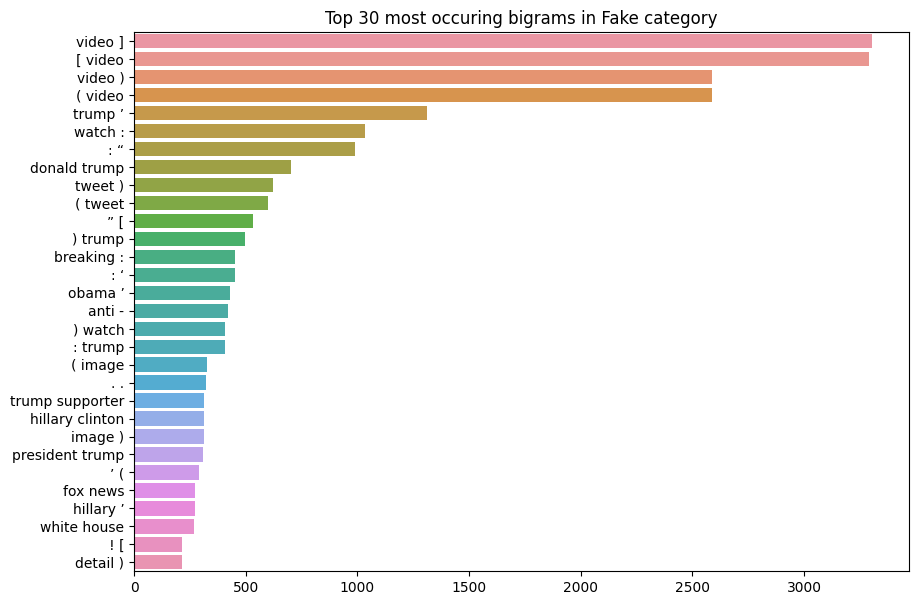

In [30]:
top_k = 30
fig, ax = plt.subplots(figsize=(10, 7))
val_counts = pd.Series(nltk.ngrams(all_tokens_fake, 2)).value_counts()[:top_k]
sns.barplot(y=val_counts.index.map(lambda x: " ".join(x)), x=val_counts, ax=ax)
ax.set_title(f"Top {top_k} most occuring bigrams in Fake category");

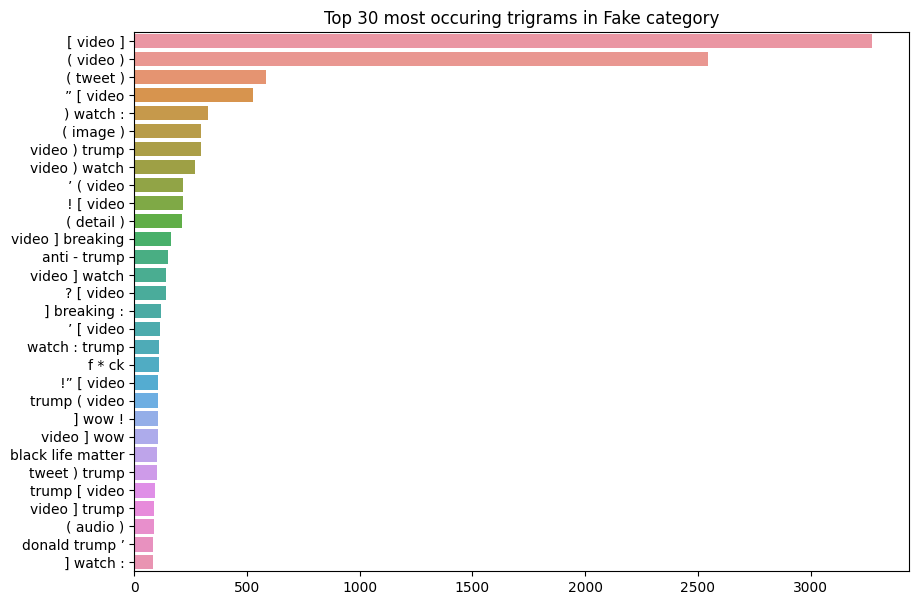

In [31]:
top_k = 30
fig, ax = plt.subplots(figsize=(10, 7))
val_counts = pd.Series(nltk.ngrams(all_tokens_fake, 3)).value_counts()[:top_k]
sns.barplot(y=val_counts.index.map(lambda x: " ".join(x)), x=val_counts, ax=ax)
ax.set_title(f"Top {top_k} most occuring trigrams in Fake category");

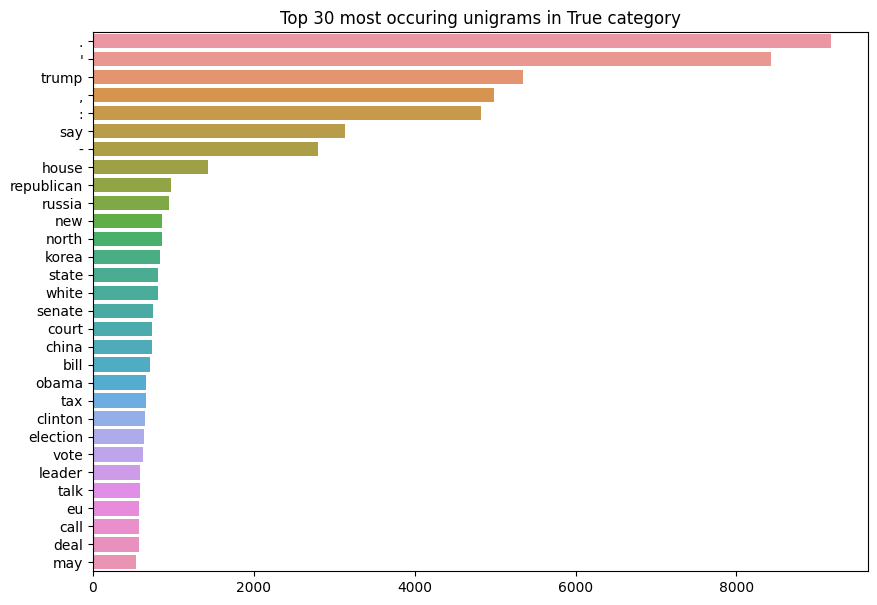

In [32]:
top_k = 30
fig, ax = plt.subplots(figsize=(10, 7))
val_counts = all_tokens_truth.value_counts()[:top_k]
sns.barplot(y=val_counts.index, x=val_counts, ax=ax)
ax.set_title(f"Top {top_k} most occuring unigrams in True category");

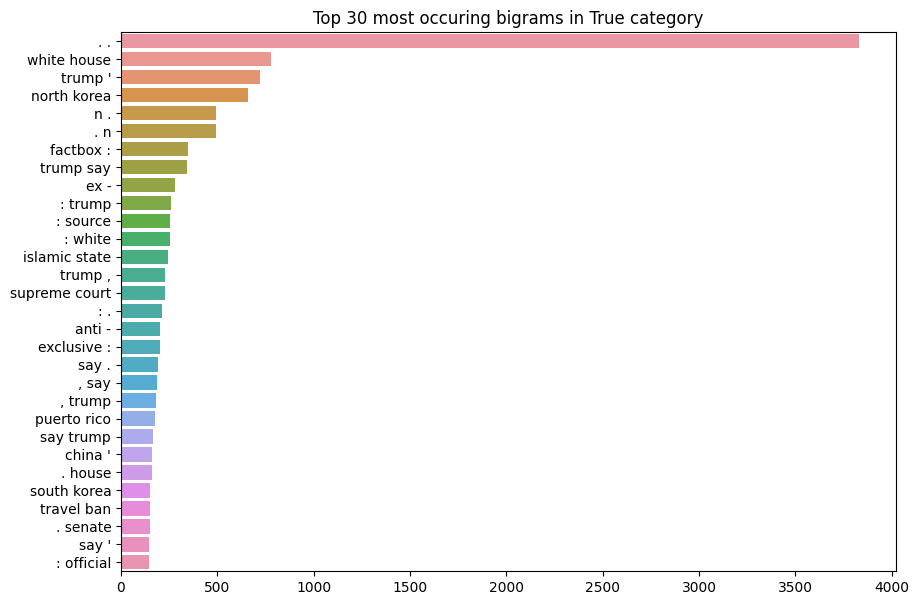

In [33]:
top_k = 30
fig, ax = plt.subplots(figsize=(10, 7))
val_counts = pd.Series(nltk.ngrams(all_tokens_truth, 2)).value_counts()[:top_k]
sns.barplot(y=val_counts.index.map(lambda x: " ".join(x)), x=val_counts, ax=ax)
ax.set_title(f"Top {top_k} most occuring bigrams in True category");

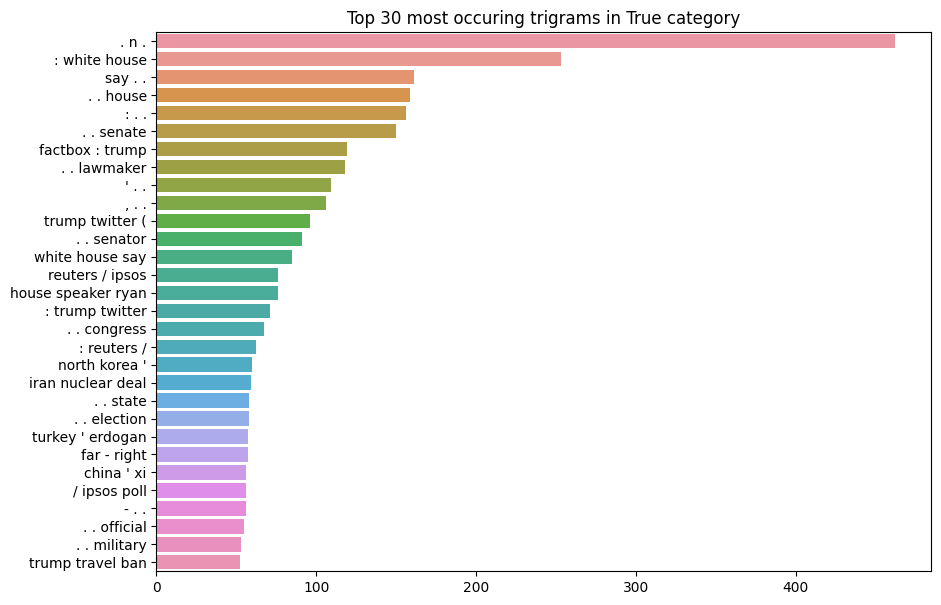

In [34]:
top_k = 30
fig, ax = plt.subplots(figsize=(10, 7))
val_counts = pd.Series(nltk.ngrams(all_tokens_truth, 3)).value_counts()[:top_k]
sns.barplot(y=val_counts.index.map(lambda x: " ".join(x)), x=val_counts, ax=ax)
ax.set_title(f"Top {top_k} most occuring trigrams in True category");

Observation:
- Except for the terms `trump` and `video`, the top 13 unigrams consists of special characters like `!`, `”`
- Many fake titles seem to contain a word in parathesis like `[VIDEO]` or `(IMAGE)`

How many of these parenthesised terms are actually fakes?

In [35]:
has_parenthesised_terms_regex = r"[\(\[](video|audio|tweet|image|detail)[\)\]]"
df_parenthesised = df_news[df_news["title"].str.lower().str.contains(has_parenthesised_terms_regex)]

/tmp/ipykernel_2186/2316352671.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_parenthesised = df_news[df_news["title"].str.lower().str.contains(has_parenthesised_terms_regex)]


In [36]:
print(f"There are {df_parenthesised.shape[0]} that match parenthesised term pattern. Of these, {df_parenthesised.is_fake.sum()} are fakes.")
classification_ratio = df_parenthesised.is_fake.sum() / df_news.is_fake.sum() * 100
print(f"Using this heuristic, we would be able to classify {classification_ratio:0.2f} % of the fakes")

There are 6247 that match parenthesised term pattern. Of these, 6247 are fakes.
Using this heuristic, we would be able to classify 34.91 % of the fakes


Let us train a simple model and see its results.

In [37]:
# Define splits based on publication date
split_date = "2017-10-01"

df_news["split_name"] = None

# Put older articles in the train split
df_news.loc[df_news["published_at"] < split_date, "split_name"] = "train"

# Put the rest of the articles in the evaluation split
df_news["split_name"] = df_news["split_name"].fillna("eval")



df_news_train = df_news[df_news.split_name == "train"]
df_news_eval = df_news[df_news.split_name == "eval"]

df_news.groupby(["split_name", "is_fake"]).count()[["title"]]

title
split_name is_fake       
eval       False     8430
           True      1128
train      False    12396
           True     16769

In [38]:
def preprocess_title(title):
    tokens = tokenize(title)
    return " ".join([t for t in tokens])

vectorizer = TfidfVectorizer(preprocessor=preprocess_title)
vectorizer.fit(df_news_train["title"])

X_train = vectorizer.transform(df_news_train["title"])
y_train = df_news_train["is_fake"]
X_eval = vectorizer.transform(df_news_eval["title"])
y_eval = df_news_eval["is_fake"]

classifier = LogisticRegression().fit(X_train, y_train)

y_pred = classifier.predict(X_eval)

print(" Classification Report")
print("-----------------------")
print(classification_report(y_true=y_eval, y_pred=y_pred))

df_model_output = pd.DataFrame({
    "weights": classifier.coef_[0],
    "feature_name": vectorizer.get_feature_names_out() 
})

 Classification Report
-----------------------
              precision    recall  f1-score   support

       False       0.99      0.94      0.97      8430
        True       0.69      0.93      0.79      1128

    accuracy                           0.94      9558
   macro avg       0.84      0.94      0.88      9558
weighted avg       0.95      0.94      0.94      9558



The training set is more or less balanced but the evaluation set less so.

The somewhat good performance achieved by a simple model indicates that this data set may not be good. We saw indications of the poor data quality during the EDA as well.

Now, the question is what terms are important for the classifier?

In [39]:
df_model_output.sort_values("weights", ascending=True).head(5)

,weights,feature_name
12611,-7.101704,say
5561,-5.521861,factbox
7201,-4.581923,house
12803,-4.025566,seek
12849,-3.937834,senate


In [40]:
df_model_output.sort_values("weights", ascending=False).head(5)

,weights,feature_name
15484,18.676497,video
15697,8.450316,watch
7049,8.033589,hillary
6483,7.969204,gop
2118,7.729298,breaking


In [41]:
BAD_TOKENS = ["video", "watch", "factbox", "say", "breaking"]

def preprocess_title(title):
    tokens = tokenize(title)
    return " ".join([t for t in tokens if t not in BAD_TOKENS])

vectorizer = TfidfVectorizer(preprocessor=preprocess_title)
vectorizer.fit(df_news_train["title"])

X_train = vectorizer.transform(df_news_train["title"])
y_train = df_news_train["is_fake"]
X_eval = vectorizer.transform(df_news_eval["title"])
y_eval = df_news_eval["is_fake"]

classifier = LogisticRegression().fit(X_train, y_train)

y_pred = classifier.predict(X_eval)

print(" Classification Report")
print("-----------------------")
print(classification_report(y_true=y_eval, y_pred=y_pred))

df_model_output = pd.DataFrame({
    "weights": classifier.coef_[0],
    "feature_name": vectorizer.get_feature_names_out() 
})

 Classification Report
-----------------------
              precision    recall  f1-score   support

       False       0.99      0.91      0.95      8430
        True       0.58      0.92      0.71      1128

    accuracy                           0.91      9558
   macro avg       0.78      0.91      0.83      9558
weighted avg       0.94      0.91      0.92      9558



In [42]:
df_model_output.sort_values("weights", ascending=True).head(5)

,weights,feature_name
7199,-4.711655,house
12800,-4.228047,seek
12846,-4.170853,senate
8431,-4.073514,lawmaker
9672,-4.027724,myanmar


In [43]:
df_model_output.sort_values("weights", ascending=False).head(5)

,weights,feature_name
7047,8.761065,hillary
6481,8.277661,gop
11497,4.996729,racist
4651,4.691198,donald
14943,4.428679,tweet


### Article Texts

In [44]:
# Remove duplicates
df_news = df_news[~df_news[["text"]].duplicated()].copy()

In [45]:
with pd.option_context("max_colwidth", None):
    display(df_news[df_news.is_fake][["text", "is_fake"]].sample(1))

,text,is_fake
12619,"WHY WAS BRAVERMAN ON TRANSITION TEAM FOR OBAMA/BIDEN 2009 AND THEN CEO TO CLINTON FOUNDATION? A LITTLE INCESTUOUS DON T YA THINK? Podesta tells Tanden the mole is Eric Braverman to which she replies, Holy Moses! Eric Braverman was the CEO Of the Clinton Foundation. He abruptly resigned a short time later after being pushed out by long-time Clinton loyalists who had apparently grown very comfortable with the status quo of accepting donations from questionable foreign donors.Rumors are he fled the country WE CANNOT CONFIRMMore on Braverman:In December [2014], the board of the Bill, Hillary and Chelsea Clinton Foundation approved a salary of more than $395,000, plus bonus, for its Yale-educated CEO, Eric Braverman, while voting to extend his board term through 2017, according to sources familiar with the arrangement. Braverman, who had worked with Chelsea Clinton at the prestigious McKinsey & Company consultancy, had been brought in with the former first daughter s support to help impose McKinsey-like management rigor to a foundation that had grown into a $2 billion charitable powerhouse.But in January, only weeks after the board s show of support and just a year and a half after Braverman arrived, he abruptly resigned, and sources tell Politico his exit stemmed partly from a power struggle inside the foundation between and among the coterie of Clinton loyalists who have surrounded the former president for decades and who helped start and run the foundation. Some, including the president s old Arkansas lawyer Bruce Lindsey, who preceded Braverman as CEO, raised concerns directly to Bill Clinton about the reforms implemented by Braverman, according to sources, and felt themselves marginalized by the growing influence of Chelsea Clinton and the new CEO she had helped recruit.The previously untold saga of Braverman s brief, and occasionally fraught tenure trying to navigate the Clintons insular world highlights the challenges the family has faced trying to impose rigorous oversight onto a vast global foundation that relies on some of the same loyal megadonors Hillary Clinton will need for the presidential run sources have said she is all but certain to launch later this year.Already, a spate of recent news stories in Politico and elsewhere have highlighted questions about the foundation s aggressive fundraising both before and during Braverman s tenure, including the news that the foundation had been accepting contributions from foreign governments with lax oversight from the State Department when Hillary Clinton was secretary of state. The foundation has been Clinton s main public platform since she left State in February 2013.The hiring a few months later of Braverman, who had been a partner in McKinsey s Washington office, was seen as validation of Chelsea Clinton s view that the foundation needed to address recommendations from a 2011 audit for tighter governance and budgeting, as well as more comprehensive policies to vet donors and avoid conflicts of interest.When Braverman arrived to replace Lindsey as CEO, he moved quickly to adopt the auditor s recommendations, and then some. He diversified the foundation s board beyond the Clintons and their longtime political allies and restructured its finance department. He oversaw the creation of a $250 million endowment and implemented data-driven analytics to measure the effectiveness of foundation programs.No public explanation was offered for Braverman s resignation.",True


In [46]:
with pd.option_context("max_colwidth", None):
    display(df_news[df_news.is_true][["text", "is_fake"]].sample(1))

,text,is_fake
25729,"WASHINGTON (Reuters) - Global warming helped fuel the hottest year on record in 2016, with greenhouse gas concentrations reaching a new high, a U.S. government report released on Thursday said. The report from the National Oceanic and Atmospheric Administration also cited a strong El Nino cycle as a factor behind the third consecutive year of record global warmth.",False


In [47]:
with pd.option_context("max_colwidth", None):
    display(df_news[df_news.is_fake][["text", "is_fake"]].head(1))

,text,is_fake
0,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",True


Cursory observations by simply inspecting the body of randomly selected articles:
1. The body of the articles (the `text` field) have been pre-processed in a somewhat bad way.
   - Bad concatenation of paragraphs: "decency.Republicans" -- no space between the paragraphs. Check article with index 7241
   - Apostrophes removed without considering contractions like "don t" or "Democratic Party s presidential". Check index 261
2. The body of some of articles seem to consists of a concatenation of multiple tweets. Check index 0
   - Fake articles seem to have a lot of Twitter mentions meaning usage of the @ character
3. Almost all articles with the truthful label contains the term "Reuters" in their body.
   - Problematic as a trained model may extract the association between the term "Reuters" and truth label, leading to a bad model. 
   - This can be alleviated by a preprocessing function that removes or replaces Reuters with another news agency.